In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [42]:
df= pd.read_csv('../data/train/D1training.csv')

In [43]:
df.drop(columns=['index','r2_iram1622', 'r3_iram1622', 'r7_iram1622', 'r28_iram1622'], inplace=True)

In [44]:
X = df[['fe2o3', 'g45µ', 'pf', 'al2o3', 'caot']].values
y = df['r1_iram1622'].values

In [45]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [46]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Convertir a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [48]:
# --- 2. Definir la red neuronal con tercera capa oculta ---
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # Nueva capa oculta
        self.fc4 = nn.Linear(hidden_size, 1)           # Capa de salida
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))  # Nueva capa oculta
        x = self.fc4(x)
        return x


In [49]:
# --- 3. GridSearch Manual ---
hidden_sizes = [32, 64, 128]
dropout_rates = [0.0, 0.2, 0.5]
learning_rates = [0.001, 0.01]
epochs_list = [300, 500]

In [50]:
# Crear el modelo
#input_size = X_train.shape[1]
#hidden_size = 64  # Número de neuronas en las capas ocultas
#dropout_rate = 0.2
#model = NeuralNet(input_size, hidden_size, dropout_rate)

In [51]:
# --- 3. Configurar el optimizador y la función de pérdida ---
#criterion = nn.MSELoss()  # Pérdida estándar (puedes cambiar a L1Loss o SmoothL1Loss si prefieres)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
# --- 4. Función para guardar el modelo ---
output_dir = "saved_models"
os.makedirs(output_dir, exist_ok=True)  # Crear directorio si no existe

In [53]:
def save_model(model, metric_value, metric_name):
    # Crear el nombre del archivo con la métrica
    model_name = f"best_model_nn_{metric_name}.pth"
    model_path = os.path.join(output_dir, model_name)
    
    # Guardar los pesos del modelo
    torch.save(model.state_dict(), model_path)
    print(f"Modelo guardado: {model_path}")

In [61]:
# Variables para rastrear el mejor modelo
best_rmse = float('inf')
best_mae = None
best_r2 = None
best_model_state = None
best_params = {}

In [62]:
# Iterar sobre las combinaciones de hiperparámetros
for hidden_size in hidden_sizes:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            for epochs in epochs_list:
                print(f"Entrenando con hidden_size={hidden_size}, dropout_rate={dropout_rate}, "
                      f"learning_rate={learning_rate}, epochs={epochs}")

                # Crear el modelo
                model = NeuralNet(input_size=X_train.shape[1], hidden_size=hidden_size, dropout_rate=dropout_rate)
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                criterion = nn.MSELoss()

                # Entrenamiento
                for epoch in range(epochs):
                    model.train()
                    predictions = model(X_train)
                    loss = criterion(predictions, y_train)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Evaluación
                model.eval()
                with torch.no_grad():
                    predictions = model(X_test)
                    rmse = torch.sqrt(torch.mean((predictions - y_test) ** 2)).item()
                    mae = torch.mean(torch.abs(predictions - y_test)).item()
                    r2 = r2_score(y_test.numpy(), predictions.numpy())

                print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

                # Guardar el mejor modelo basado en RMSE
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_mae = mae
                    best_r2 = r2
                    best_model_state = model.state_dict()
                    best_params = {
                        "hidden_size": hidden_size,
                        "dropout_rate": dropout_rate,
                        "learning_rate": learning_rate,
                        "epochs": epochs
                    }

# Guardar el mejor modelo al final
save_model(model, best_rmse, "rmse")

# Mostrar los mejores hiperparámetros y métricas finales
print("\nMejores hiperparámetros:")
print(best_params)
print(f"Mejor RMSE: {best_rmse:.4f}")
print(f"Mejor MAE: {best_mae:.4f}")
print(f"Mejor R²: {best_r2:.4f}")

Entrenando con hidden_size=32, dropout_rate=0.0, learning_rate=0.001, epochs=300
RMSE: 2.9721, MAE: 2.2965, R²: -1.3591
Entrenando con hidden_size=32, dropout_rate=0.0, learning_rate=0.001, epochs=500
RMSE: 2.3314, MAE: 1.8905, R²: -0.4516
Entrenando con hidden_size=32, dropout_rate=0.0, learning_rate=0.01, epochs=300
RMSE: 1.8886, MAE: 1.5159, R²: 0.0474
Entrenando con hidden_size=32, dropout_rate=0.0, learning_rate=0.01, epochs=500
RMSE: 1.8816, MAE: 1.5218, R²: 0.0545
Entrenando con hidden_size=32, dropout_rate=0.2, learning_rate=0.001, epochs=300
RMSE: 2.5987, MAE: 2.1539, R²: -0.8035
Entrenando con hidden_size=32, dropout_rate=0.2, learning_rate=0.001, epochs=500
RMSE: 2.1290, MAE: 1.7867, R²: -0.2105
Entrenando con hidden_size=32, dropout_rate=0.2, learning_rate=0.01, epochs=300
RMSE: 1.8291, MAE: 1.5194, R²: 0.1065
Entrenando con hidden_size=32, dropout_rate=0.2, learning_rate=0.01, epochs=500
RMSE: 1.8607, MAE: 1.4452, R²: 0.0754
Entrenando con hidden_size=32, dropout_rate=0.5,

In [56]:
# --- 6. Evaluar el mejor modelo ---
model.eval()  # Modo evaluación
with torch.no_grad():
    predictions = model(X_test)
    
    # Calcular métricas
    mse = criterion(predictions, y_test).item()  # MSE
    mae = torch.mean(torch.abs(predictions - y_test)).item()  # MAE
    rmse = torch.sqrt(torch.mean((predictions - y_test) ** 2)).item()  # RMSE
    r2 = r2_score(y_test.numpy(), predictions.numpy())  # R² usando scikit-learn

In [57]:
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

MSE: 3.4541, MAE: 1.4748, RMSE: 1.8585, R²: 0.0775


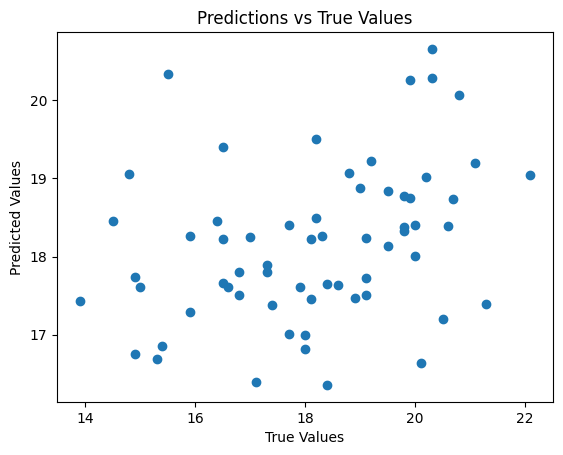

In [58]:
# --- 7. Visualización de resultados ---
# Convertir predicciones y valores reales a numpy para graficar
predictions_np = predictions.numpy()
y_test_np = y_test.numpy()

plt.scatter(y_test_np, predictions_np)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs True Values")
plt.show()

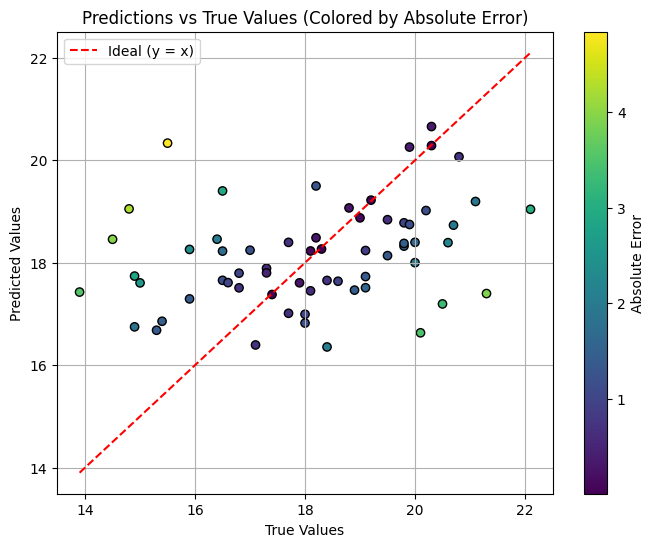

In [59]:
# Calcular el error absoluto
errors = np.abs(y_test_np - predictions_np)

# Crear la gráfica de dispersión
plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_test_np, predictions_np, c=errors, cmap='viridis', edgecolor='k')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--', label='Ideal (y = x)')

# Personalización del gráfico
plt.colorbar(scatter, label='Absolute Error')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs True Values (Colored by Absolute Error)")
plt.legend()
plt.grid(True)
plt.show()

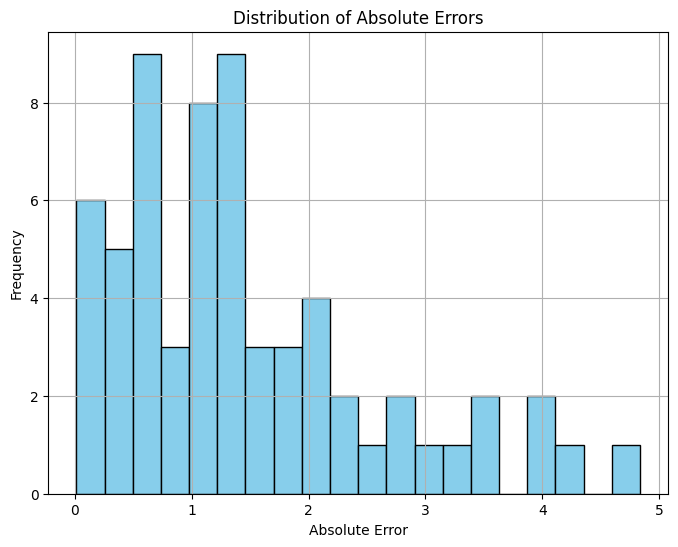

In [60]:
# Histograma del error absoluto
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Errors')
plt.grid(True)
plt.show()